## CSCN8030 - Artificial Intelligence for Business Decisions and Transformation
### Project 1 - Superstore Analysis

Group 6:
- Team Members:
    - Rohit Totlani - 8914803
    - Pradeepti Kasam - 8965985
    - Mohammed Benkhial -8928209

___

Kaggle DataSet Link:

[Superstore Dataset](https://www.kaggle.com/datasets/arifmia/supershop-dataset)

#### Installing and importing libraries

In [1]:
%pip install statsmodels
%pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

<br>

#### Data Preprocessing

In [3]:
store_df = pd.read_excel('superstore.xlsx')
store_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


<br>

In [4]:
store_df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


There are no null values in the dataset.

<br>

Converting "Order Date" to Datetime format.

In [5]:
store_df['Order Date'] = pd.to_datetime(store_df['Order Date'])

<br>

Engineering custom features

In [6]:
#Feature Engineering
store_df['Order Year'] = store_df['Order Date'].dt.year
store_df['Order Month'] = store_df['Order Date'].dt.month
store_df['Order Day'] = store_df['Order Date'].dt.day
store_df['Order DayOfWeek'] = store_df['Order Date'].dt.dayofweek

In [7]:
store_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Order Year,Order Month,Order Day,Order DayOfWeek
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,11,8,1
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,11,8,1
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,6,12,6
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,10,11,6
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,10,11,6


<br>

Dropping unnecessary columns

In [9]:
#Dropping unnecessary columns
store_df.drop(columns=['Row ID', 'Customer Name', 'Postal Code'], inplace=True)

<br>

Checking for duplicate rows and dropping them

In [10]:
#check duplicate rows
store_df.duplicated().sum()

#drop duplicate rows
store_df.drop_duplicates(inplace=True)

<br>

#### Detecting and removing Outliers

<Axes: xlabel='Sales'>

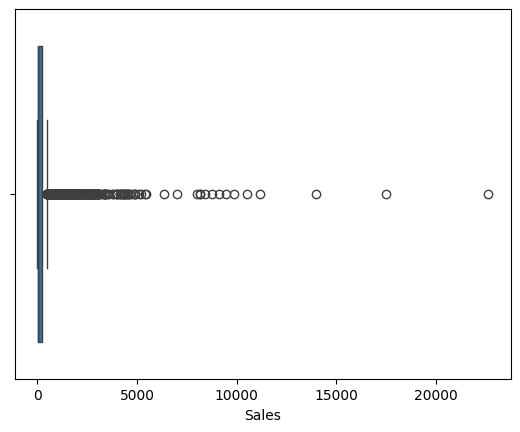

In [11]:
#identify outliers
sns.boxplot(x=store_df['Sales'])


In [12]:
#IQR method to identify
Q1 = store_df['Sales'].quantile(0.25)
Q3 = store_df['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = store_df[(store_df['Sales'] < lower_bound) | (store_df['Sales'] > upper_bound)]
outliers['Sales'].value_counts()


,count
Sales,
603.920,5
542.940,5
629.950,5
801.568,4
979.950,4
...,...
2025.360,1
1799.994,1
826.620,1


In [13]:
# Cap outliers
store_df['Sales'] = store_df['Sales'].clip(lower=lower_bound, upper=upper_bound)

In [14]:
store_df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Region,...,Product Name,Sales,Quantity,Discount,Profit,Order Year,Order Month,Order Day,Order DayOfWeek,Profit Margin
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,...,Bush Somerset Collection Bookcase,261.960,2,0.00,41.9136,2016,11,8,1,0.1600
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",498.930,3,0.00,219.5820,2016,11,8,1,0.3000
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,West,...,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.00,6.8714,2016,6,12,6,0.4700
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,...,Bretford CR4500 Series Slim Rectangular Table,498.930,5,0.45,-383.0310,2015,10,11,6,-0.4000
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,...,Eldon Fold 'N Roll Cart System,22.368,2,0.20,2.5164,2015,10,11,6,0.1125


___

### Exploratory Data Analysis (EDA)

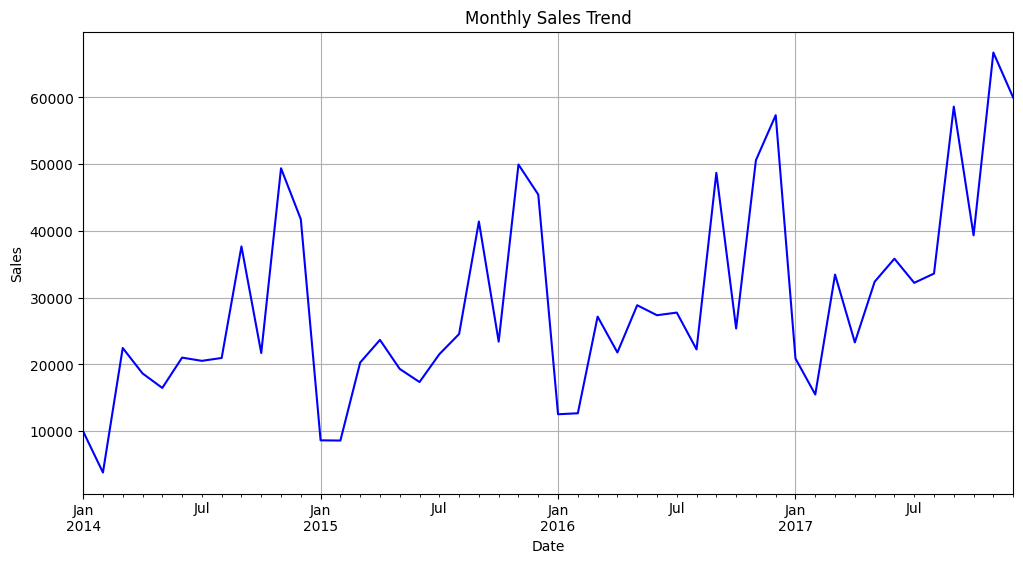

In [15]:
# Sales Trend Over Time
store_df.set_index('Order Date', inplace=True)
plt.figure(figsize=(12, 6))
store_df['Sales'].resample('ME').sum().plot(title='Monthly Sales Trend', color='b')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.show()

The graph shows a clear upward trend in sales over the period from 2015 to 2017. This indicates that the business has been growing steadily during this timeframe.
There appears to be some seasonality in the sales data as well. We can observe peaks and troughs that seem to repeat annually.

<br>

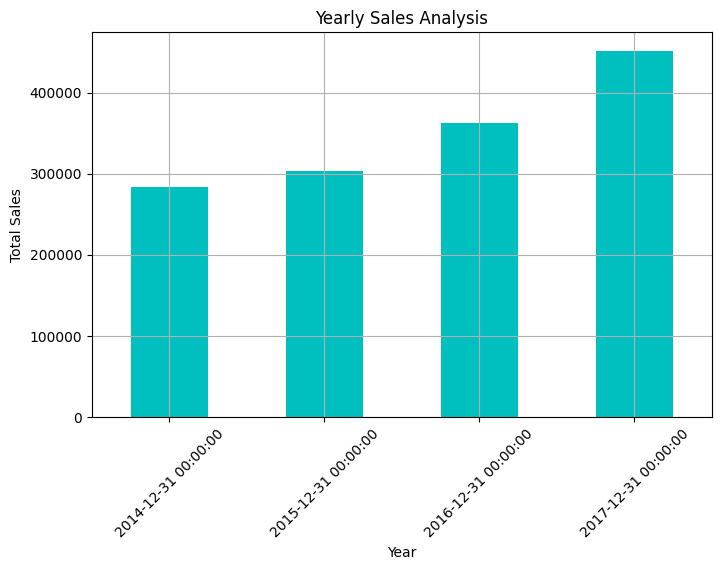

In [16]:
# Yearly Sales Analysis
yearly_sales = store_df['Sales'].resample('YE').sum()
plt.figure(figsize=(8, 5))
yearly_sales.plot(kind='bar', title='Yearly Sales Analysis', color='c')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

<br>

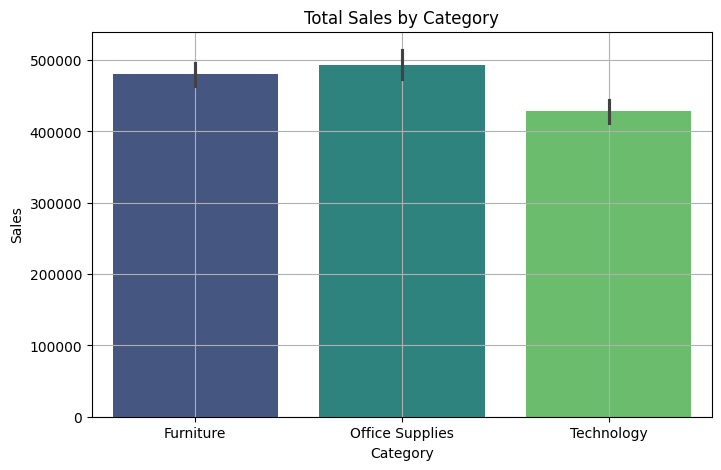

In [17]:
# Sales by Category
plt.figure(figsize=(8, 5))
sns.barplot(x='Category', y='Sales', data=store_df, estimator=sum,palette='viridis', legend=False, hue='Category')
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.grid()
plt.show()

The sales are pretty evenly spread out across the three categories with Technology sales leading marginally.

<br>

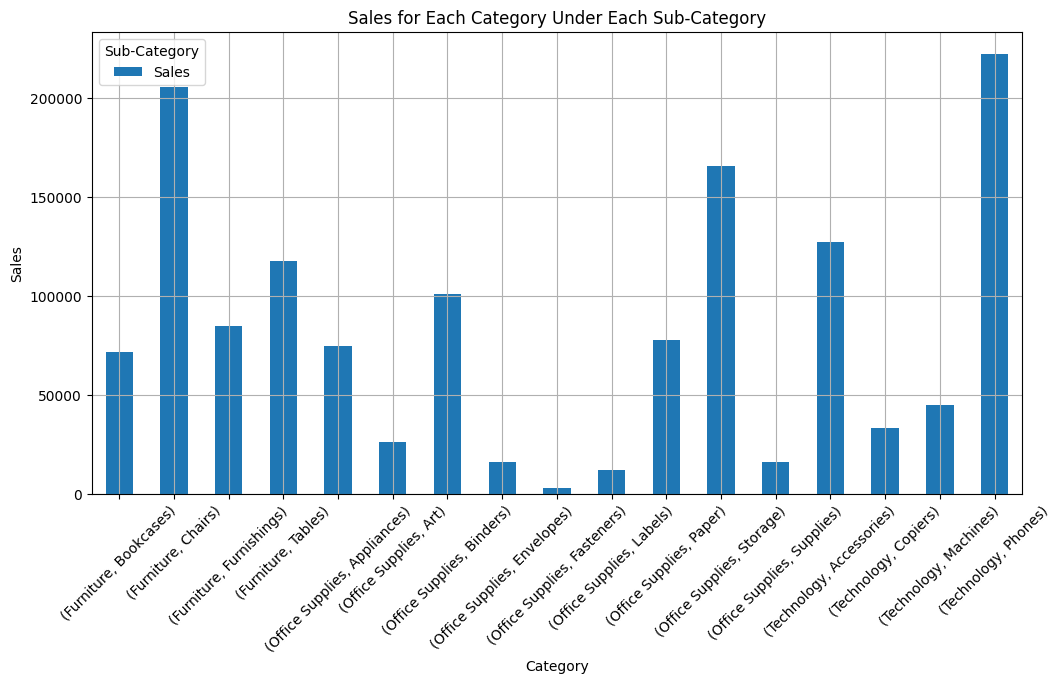

In [18]:
category_subcategory_sales = store_df.groupby(['Category', 'Sub-Category'])['Sales'].sum()

# Plot the results
category_subcategory_sales.plot(kind='bar',  figsize=(12, 6))
plt.title('Sales for Each Category Under Each Sub-Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend(title='Sub-Category')
plt.grid()
plt.show()

The graph shows that phones and chairs are the most sold items.

<br>

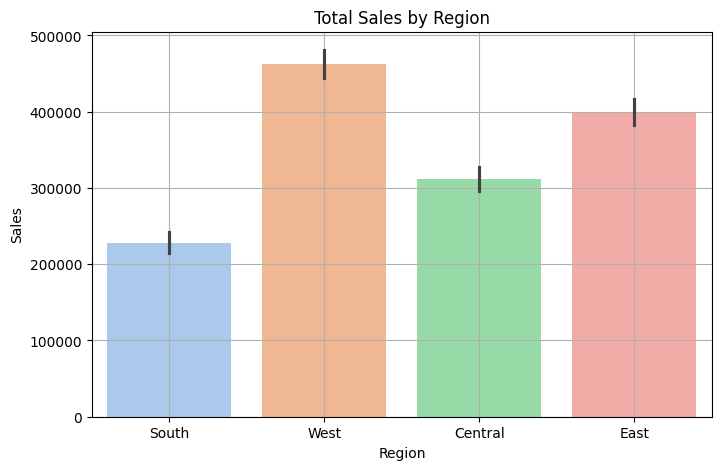

In [20]:
# Sales by Region
plt.figure(figsize=(8, 5))
sns.barplot(x='Region', y='Sales', data=store_df, estimator=sum, palette='pastel', legend=False, hue='Region')
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.grid()
plt.show()

- Highest Sales: The West region has the highest sales, exceeding 700,000.
- Lowest Sales: The South region has the lowest sales, around 400,000.

<br>

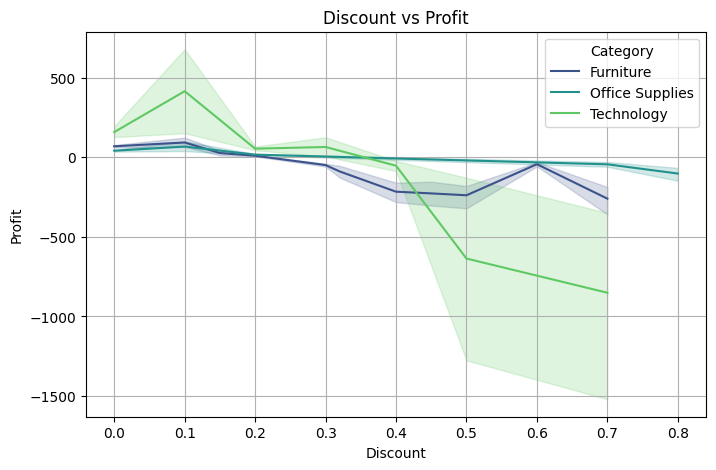

In [21]:
# Impact of Discount on Profit
plt.figure(figsize=(8, 5))
sns.lineplot(x='Discount', y='Profit', data=store_df, hue='Category', palette='viridis')
plt.title('Discount vs Profit')
plt.xlabel('Discount')
plt.ylabel('Profit')
plt.grid()
plt.show()

The graph shows a general downward trend in profit as the discount rate increases for all three product categories: Furniture, Office Supplies, and Technology. This suggests that offering higher discounts leads to lower overall profits.

<br>

### Aggregation and Forecasting Preparation

Aggregate Sales Data Monthly for Forecasting

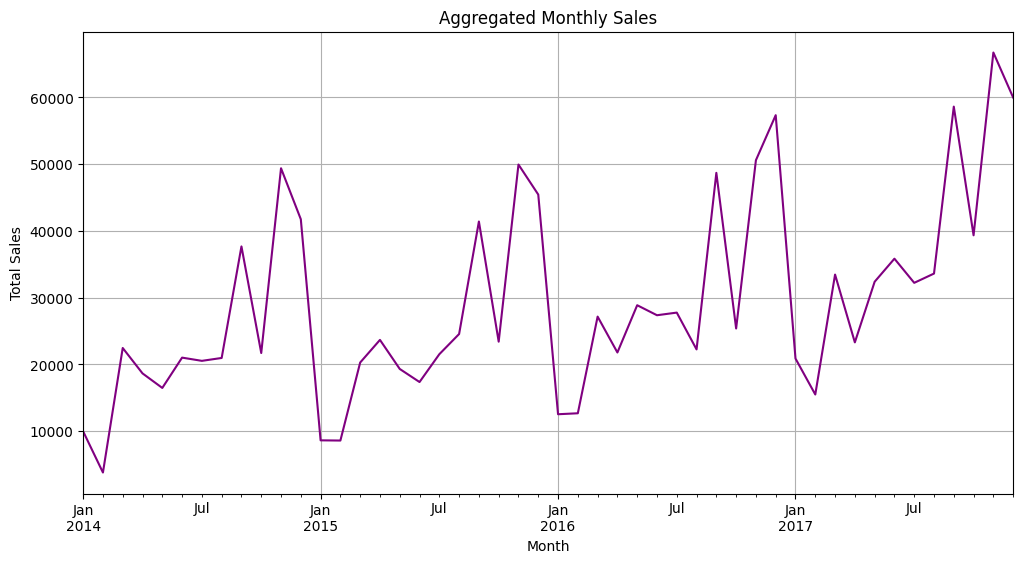

In [22]:
# Aggregate sales data by month
monthly_sales = store_df['Sales'].resample('ME').sum()

# Plot the aggregated monthly sales
plt.figure(figsize=(12, 6))
monthly_sales.plot(title='Aggregated Monthly Sales', color='purple')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid()
plt.show()

<br>

Check for Seasonality and Stationarity

In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Augmented Dickey-Fuller test to check stationarity
result = adfuller(monthly_sales)
print("ADF Statistic:", result[0].round(3))
print("p-value:", result[1].round(3))
if result[1] <= 0.05:
    print("Data is stationary.")
else:
    print("Data is not stationary. Differencing might be needed.")

ADF Statistic: -4.087
p-value: 0.001
Data is stationary.


___

### Model Selection and Training

Since the data is stationary, we can move forward with traditional time series models like ARIMA(AutoRegressive Integrated Moving Average)

In [27]:
# Split the data into training and testing sets
train_size = int(len(monthly_sales) * 0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=6.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=707.325, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=703.286, Time=1.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=703.182, Time=1.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,0)[12]             : AIC=703.089, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=703.136, Time=0.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[12]             : AIC=705.135, Time=2.74 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=704.914, Time=0.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,0)[12]             : AIC=704.985, Time=0.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=702.628, Time=0.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=703.310, Time=0.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=705.286, Time=1.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[12]             : AIC=706.127, Time=0.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=704.718, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 18.198 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -349.314
Date:                            Tue, 21 Jan 2025   AIC                            702.628
Time:                                    21:20:15   BIC                            705.739
Sample:                                01-31-2014   HQIC                           703.702
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.02

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


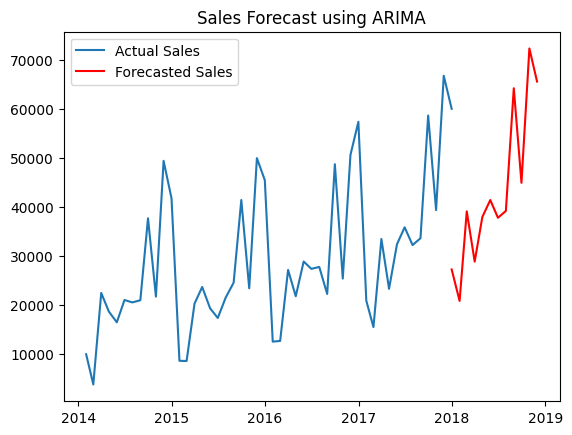

In [29]:
# Ensure stationarity using differencing if needed
auto_arima_model = auto_arima(monthly_sales, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True)
print(auto_arima_model.summary())

# Fit the best ARIMA model
best_order = auto_arima_model.order
best_seasonal_order = auto_arima_model.seasonal_order

model = ARIMA(monthly_sales, order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit()

# Forecasting future sales
forecast = model_fit.forecast(steps=12)
plt.plot(monthly_sales.index, monthly_sales, label="Actual Sales")
plt.plot(pd.date_range(monthly_sales.index[-1], periods=12, freq="ME"), forecast, label="Forecasted Sales", color='red')
plt.legend()
plt.title("Sales Forecast using ARIMA")
plt.show()

<br>

In [30]:
# RMSE calculation
rmse = np.sqrt(mean_squared_error(monthly_sales[-12:], forecast))
print(f"Improved ARIMA RMSE: {rmse:.2f}")

#MAE
mae = mean_absolute_error(monthly_sales[-12:], forecast)
print(f"Improved ARIMA MAE: {mae:.2f}")

#R2 score
r2 = r2_score(monthly_sales[-12:], forecast)
print(f"Improved ARIMA R2_score: {r2:.2f}")

Improved ARIMA RMSE: 5624.43
Improved ARIMA MAE: 5619.49
Improved ARIMA R2_score: 0.87


1. Root Mean Squared Error (RMSE):
- Value: 5624.43
- RMSE quantifies the average magnitude of forecast errors. A lower RMSE indicates better model accuracy.
Since the sales range in the graph seems to vary between 10,000 to 70,000, an RMSE of ~5,624 indicates that the forecast errors are about 8-10% of the range, which is fairly reasonable.


2. Mean Absolute Error (MAE):
- Value: 5619.49
- MAE is similar to RMSE but less sensitive to large errors (no squaring).
This value aligns closely with RMSE, which suggests there aren’t extreme forecast outliers skewing the performance metrics. The MAE confirms that the model consistently makes predictions within ~5,620 units of the actual sales.


3. R² Score (Coefficient of Determination):
- Value: 0.87
- An R² score of 0.87 means the model explains 87% of the variance in the sales data, which is very good. The closer R² is to 1, the better the model fits the data.
An R² of 0.87 suggests that the model captures the underlying patterns and trends effectively, though 13% of the variance remains unexplained.


___

LSTM (Long Short Term Memory) Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 807ms/step - loss: 0.1770 - val_loss: 0.4351
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.1611 - val_loss: 0.3931
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1392 - val_loss: 0.3472
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.1076 - val_loss: 0.2963
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1071 - val_loss: 0.2427
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0742 - val_loss: 0.1885
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0567 - val_loss: 0.1348
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0477 - val_loss: 0.0881
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0461 - val_loss: 0.0603
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0476 - val_loss: 0.0523
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0534 - val_loss: 0.0574
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0500 - val_l

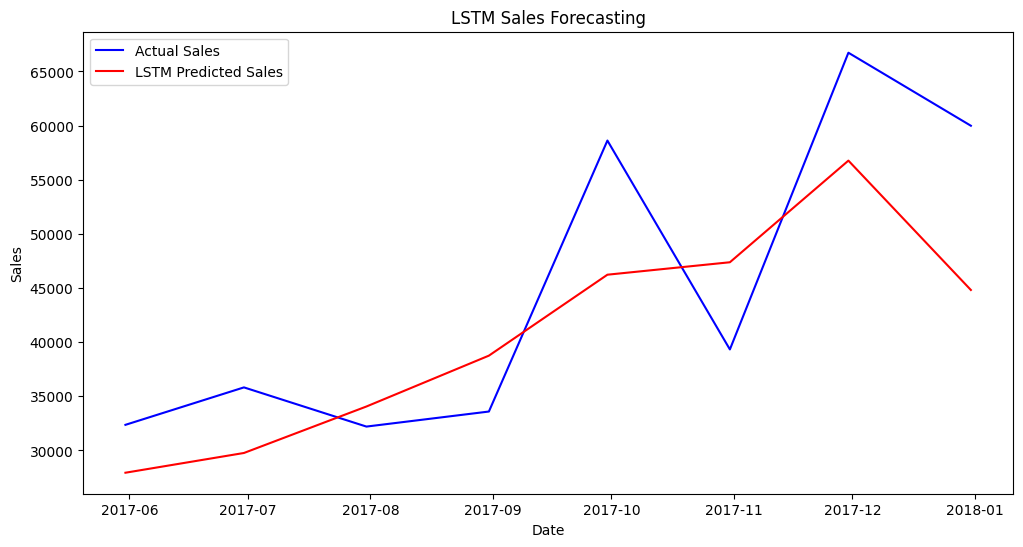

In [33]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(monthly_sales.values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 12  # Looking back 12 months
X, Y = create_sequences(scaled_data, time_step)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_test, Y_test), verbose=1)

# Predictions
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(monthly_sales[split+time_step:], predicted))
print(f"Improved LSTM RMSE: {rmse:.2f}")

#MSE
mse = mean_squared_error(monthly_sales[split+time_step:], predicted)
print(f"Improved LSTM MSE: {mse:.2f}")

#MAE
mae = mean_absolute_error(monthly_sales[split+time_step:], predicted)
print(f"Improved LSTM MAE: {mae:.2f}")

#R2_score
r2 = r2_score(monthly_sales[split+time_step:], predicted)
print(f"Improved LSTM R2_score: {r2:.2f}")



#plot predictions
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales.index[split+time_step:], monthly_sales[split+time_step:], label='Actual Sales', color='blue')
plt.plot(monthly_sales.index[split+time_step:], predicted, label='LSTM Predicted Sales', color='red')
plt.title('LSTM Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

___

#### Conclusion:
 - ARIMA gave us an R2 score of 0.87 which indicates that the model can explain 87% variance in the data.
 - LSTM gave us an R2 score of 0.56 which indicates that the model explains 56% variance in data.

<br>

#### Future Scope:
- Using the model to predict sales of individual items to optimize the inventory.
- Profitability prediction to come up with better discounting strategies.

___